In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
commits = pd.read_pickle("commits.pkl")

In [3]:
def dev_per_file(df):
    file_to_dev = defaultdict(set)
    for idx in df.index:
        files = df.loc[idx]['files']
        author = df.loc[idx]['author_name']
        if files == "":
            continue
        files = files.split(",")
        for f in files:
            file_to_dev[f].add(author)
    file_to_ndev = {k:len(v) for k,v in file_to_dev.items()}
    return pd.Series(file_to_ndev)

In [4]:

def isi915(f):
    return "drivers/gpu/drm/i915/" in f or "include/drm/i915" in f or "include/uapi/drm/i915_drm.h" in f or "Documentation/gpu/i915.rst" in f

def ismm(f):
    return "include/linux/mm.h" in f or \
            "include/linux/gfp.h" in f or \
            "include/linux/mmzone.h" in f or \
            "include/linux/memory_hotplug.h" in f or \
            "include/linux/vmalloc.h" in f or \
            f.startswith("mm/")

In [5]:
def isnetwork(f):
    return  f.startswith("net/") or\
            f.startswith("include/net/") or\
            "include/linux/in.h" in f or \
            "include/linux/net.h" in f or \
            "include/linux/netdevice.h" in f or \
            "include/uapi/linux/in.h" in f or \
            "include/uapi/linux/net.h" in f or \
            "include/uapi/linux/netdevice.h" in f

In [6]:
def isdrm(f):
    return "drivers/gpu/drm/" in f or\
            "include/drm/" in f or \
            "include/uapi/drm/" in f

In [13]:
def iskernel(f):
    return f.startswith("kernel/")

In [7]:
n_files = commits.files.map(lambda f: len(f.split(',')))
n_files.quantile([0.99, 0.999])

0.990    17.0
0.999    65.0
Name: files, dtype: float64

In [8]:
commits = commits[commits.files.map(lambda f: len(f.split(',')) <= 65)]

In [9]:
commits['isi915'] = commits.files.map(lambda f: any(map(isi915, f.split(','))))
commits['ismm'] = commits.files.map(lambda f: any(map(ismm, f.split(','))))

In [10]:
commits['isnetwork'] = commits.files.map(lambda f: any(map(isnetwork, f.split(','))))

In [11]:
commits['isdrm'] = commits.files.map(lambda f: any(map(isdrm, f.split(','))))

In [14]:
commits['iskernel'] = commits.files.map(lambda f: any(map(iskernel, f.split(','))))

In [15]:
i915 = commits[commits.isi915]
mm = commits[commits.ismm]

In [16]:
network = commits[commits.isnetwork]

In [17]:
drm = commits[commits.isdrm]

In [26]:
kernel = commits[commits.iskernel]

# dev per file 

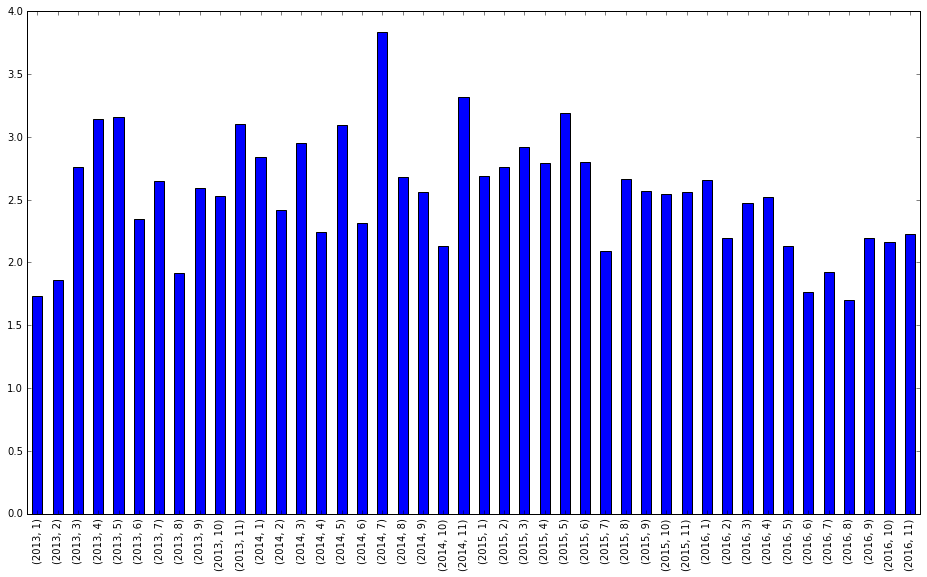

In [74]:
result = {}
for year in range(2013, 2017):
    for month in range(1, 12):
        subset = i915[i915.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        result[(year, month)] = dev_per_file(subset).describe()
plt.figure(figsize=(16,9), facecolor="white")
df_i915 = pd.DataFrame(result).T
df_i915['mean'].plot('bar', color="blue")

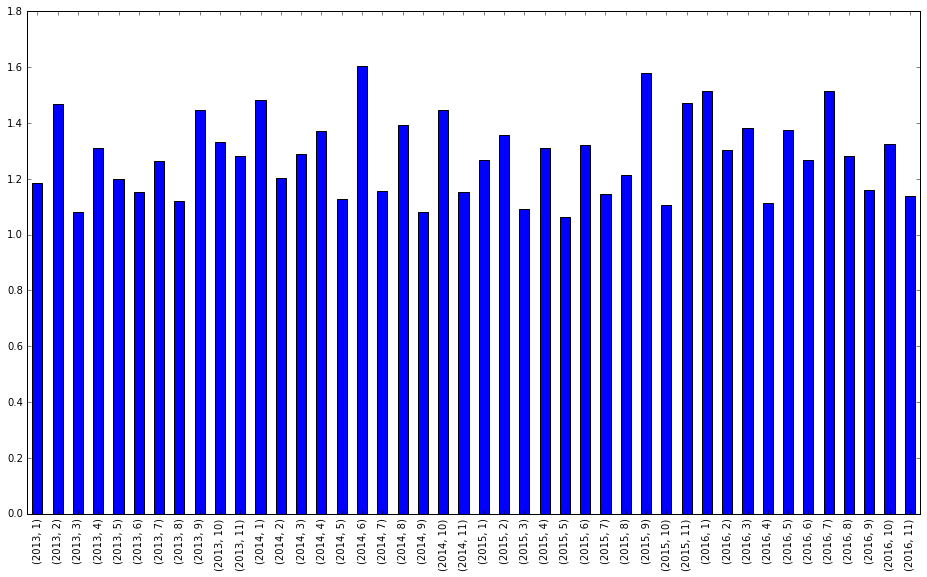

In [75]:
result = {}
for year in range(2013, 2017):
    for month in range(1, 12):
        subset = mm[mm.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        result[(year, month)] = dev_per_file(subset).describe()
plt.figure(figsize=(16,9), facecolor="white")
df_mm = pd.DataFrame(result).T
df_mm['mean'].plot('bar', color="blue")

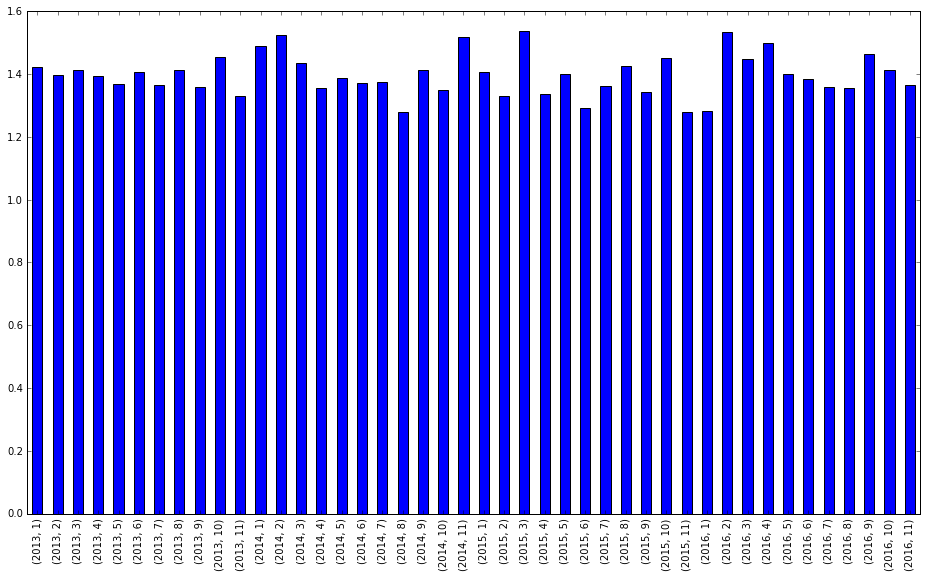

In [76]:
result = {}
for year in range(2013, 2017):
    for month in range(1, 12):
        subset = network[network.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        result[(year, month)] = dev_per_file(subset).describe()
plt.figure(figsize=(16,9), facecolor="white")
df_network = pd.DataFrame(result).T
df_network['mean'].plot('bar', color="blue")

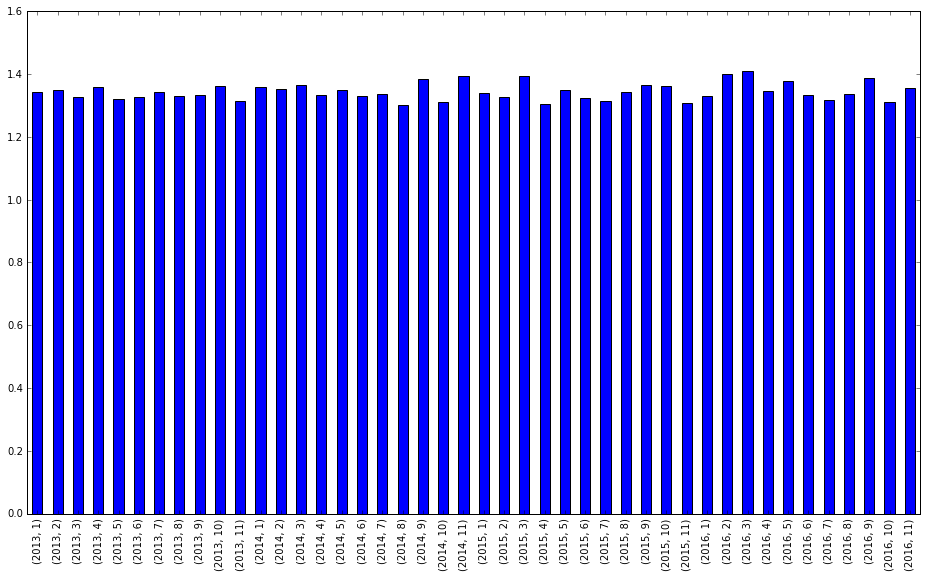

In [77]:
result = {}
for year in range(2013, 2017):
    for month in range(1, 12):
        subset = commits[commits.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        result[(year, month)] = dev_per_file(subset).describe()
plt.figure(figsize=(16,9), facecolor="white")
df_all = pd.DataFrame(result).T
df_all['mean'].plot('bar', color="blue")

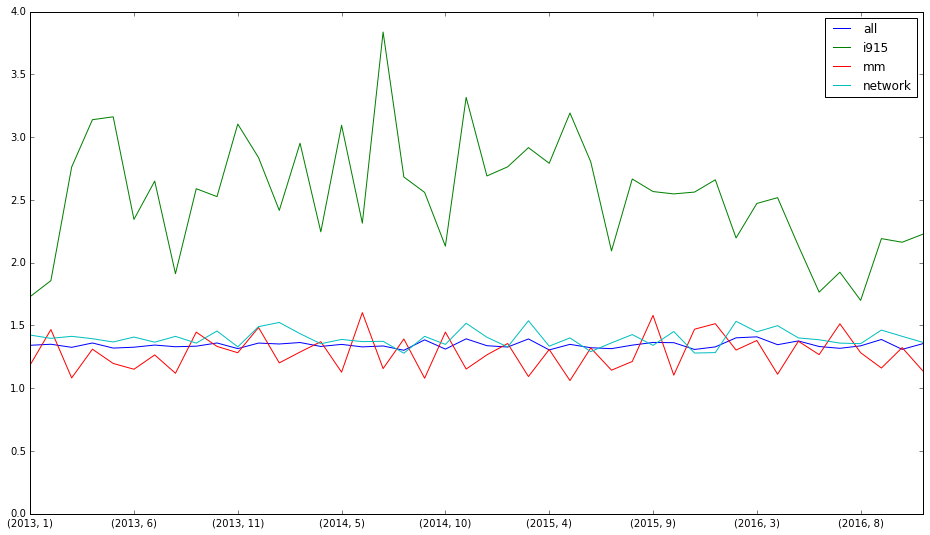

In [79]:
pd.DataFrame({
        'i915': df_i915['mean'], 
        'mm': df_mm['mean'], 
        'network': df_network['mean'], 
        'all': df_all['mean'],
}).plot(figsize=(16,9), ylim=[0,4.0])

# more accurate

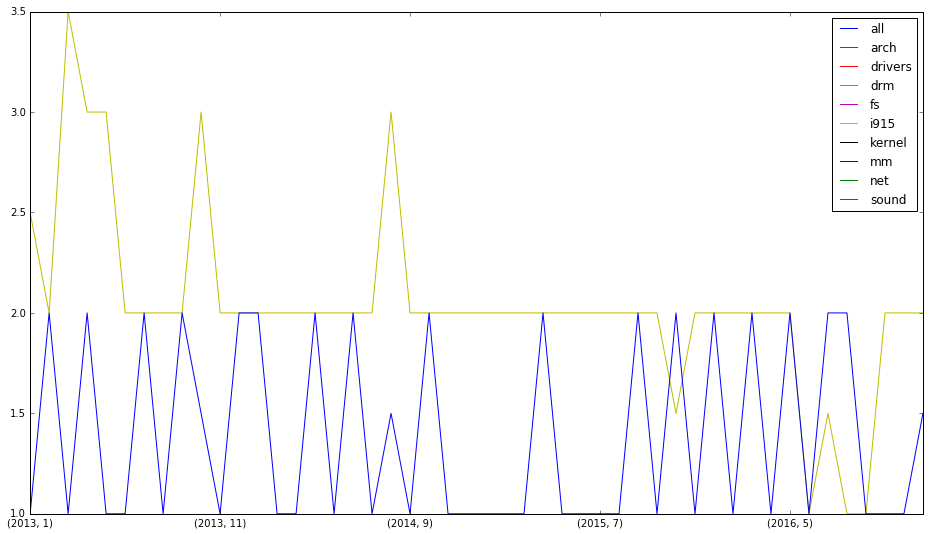

In [18]:
result = {}
for year in range(2013, 2017):
    for month in range(1, 13):
        subset = commits[commits.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        files_info = dev_per_file(subset)
        result[(year, month)] = {
            'all' : files_info.median(),
            'mm' : files_info[files_info.index.map(lambda f: f.startswith("mm/"))].median(),
            'net' : files_info[files_info.index.map(lambda f: f.startswith("net/"))].median(),
            'arch' : files_info[files_info.index.map(lambda f: f.startswith("arch/"))].median(),
            'drivers' : files_info[files_info.index.map(lambda f: f.startswith("drivers/"))].median(),
            'kernel' : files_info[files_info.index.map(lambda f: f.startswith("kernel/"))].median(),
            'fs' : files_info[files_info.index.map(lambda f: f.startswith("fs/"))].median(),
            'sound' : files_info[files_info.index.map(lambda f: f.startswith("sound/"))].median(), 
            'drm': files_info[files_info.index.map(isdrm)].median(),
            'i915': files_info[files_info.index.map(isi915)].median(),
        }

pd.DataFrame(result).T.plot(figsize=(16,9))

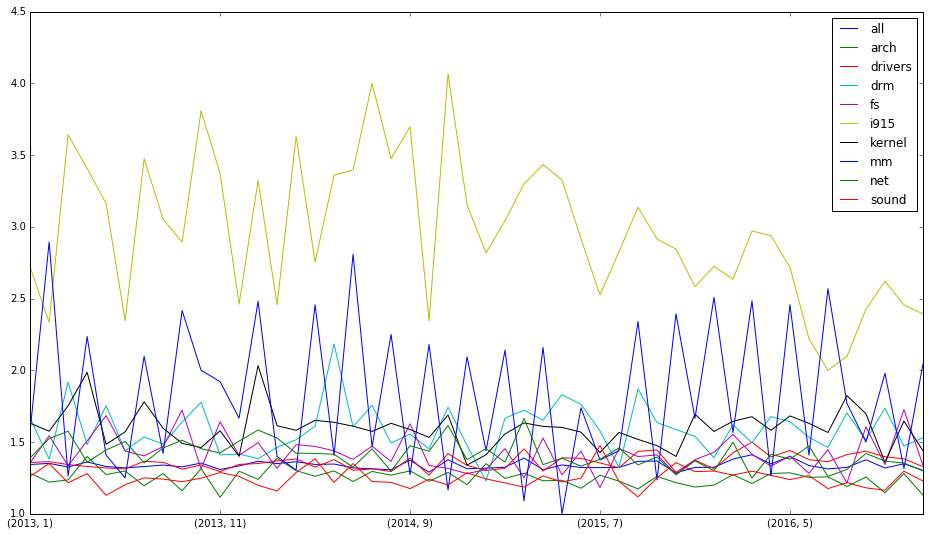

In [19]:
result = {}
for year in range(2013, 2017):
    for month in range(1, 13):
        subset = commits[commits.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        files_info = dev_per_file(subset)
        result[(year, month)] = {
            'all' : files_info.mean(),
            'mm' : files_info[files_info.index.map(lambda f: f.startswith("mm/"))].mean(),
            'net' : files_info[files_info.index.map(lambda f: f.startswith("net/"))].mean(),
            'arch' : files_info[files_info.index.map(lambda f: f.startswith("arch/"))].mean(),
            'drivers' : files_info[files_info.index.map(lambda f: f.startswith("drivers/"))].mean(),
            'kernel' : files_info[files_info.index.map(lambda f: f.startswith("kernel/"))].mean(),
            'fs' : files_info[files_info.index.map(lambda f: f.startswith("fs/"))].mean(),
            'sound' : files_info[files_info.index.map(lambda f: f.startswith("sound/"))].mean(), 
            'drm': files_info[files_info.index.map(isdrm)].mean(),
            'i915': files_info[files_info.index.map(isi915)].mean(),
        }

pd.DataFrame(result).T.plot(figsize=(16,9))

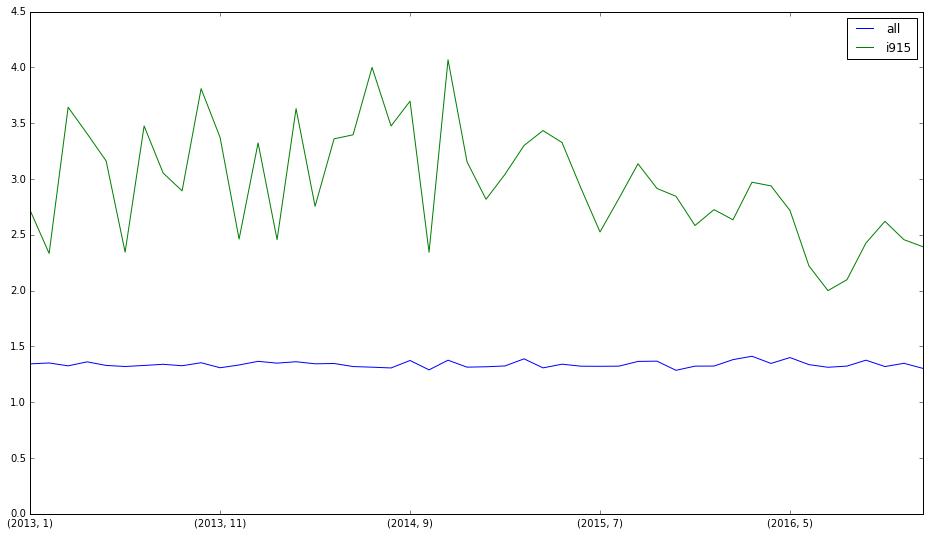

In [23]:
pd.DataFrame(result).T[['all', 'i915']].plot(figsize=(16,9), ylim=[0,4.5])

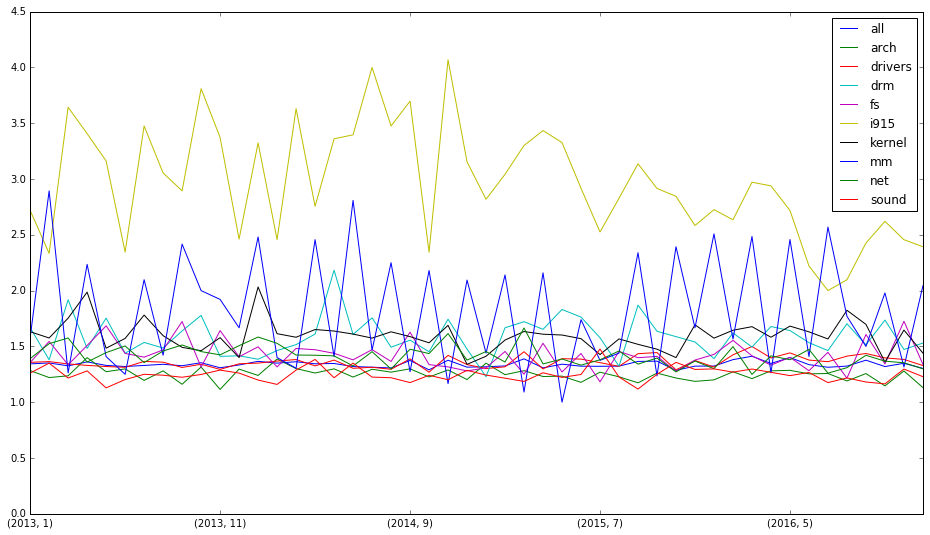

In [24]:
pd.DataFrame(result).T.plot(figsize=(16,9), ylim=[0,4.5])

In [60]:
pd.DataFrame(result).T.describe()

,all,arch,drivers,drm,fs,i915,kernel,mm,net,sound
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,1.338763,1.249799,1.360580,1.589981,1.421683,2.962657,1.595352,1.819302,1.415434,1.247867
std,0.027940,0.058826,0.050873,0.171285,0.126737,0.505743,0.136006,0.510677,0.092681,0.065089
min,1.285622,1.114629,1.268714,1.228723,1.182692,2.000000,1.339286,1.000000,1.249012,1.117647
25%,1.319754,1.215424,1.318948,1.475398,1.334489,2.568856,1.528823,1.405556,1.354333,1.216191
50%,1.331633,1.256901,1.357878,1.566888,1.408835,2.915960,1.584795,1.702899,1.415305,1.242423
75%,1.355632,1.283741,1.388621,1.684164,1.473736,3.363023,1.645138,2.238971,1.462459,1.281860
max,1.411775,1.399497,1.499195,2.182609,1.725000,4.068182,2.032787,2.893617,1.664596,1.476190


In [53]:
result = {}
for year in range(2013, 2017):
    for month in range(1, 13):
        subset = commits[commits.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        files_info = dev_per_file(subset)
        result[(year, month)] = {
            'all' : files_info.size,
            'mm' : files_info[files_info.index.map(lambda f: f.startswith("mm/"))].size,
            'net' : files_info[files_info.index.map(lambda f: f.startswith("net/"))].size,
            'arch' : files_info[files_info.index.map(lambda f: f.startswith("arch/"))].size,
            'drivers' : files_info[files_info.index.map(lambda f: f.startswith("drivers/"))].size,
            'kernel' : files_info[files_info.index.map(lambda f: f.startswith("kernel/"))].size,
            'fs' : files_info[files_info.index.map(lambda f: f.startswith("fs/"))].size,
            'sound' : files_info[files_info.index.map(lambda f: f.startswith("sound/"))].size,
            'i915': files_info[files_info.index.map(isi915)].size,
        }


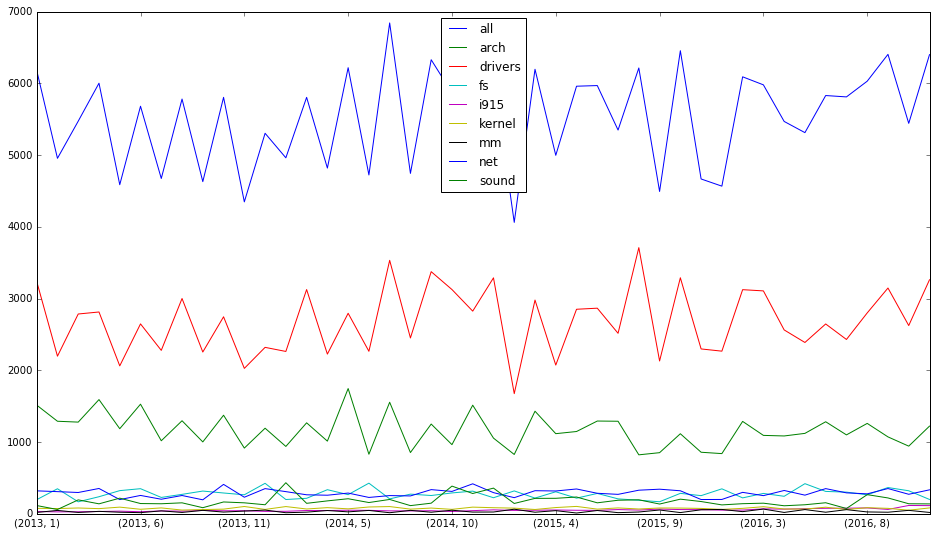

In [54]:
pd.DataFrame(result).T.plot(figsize=(16,9))

In [55]:
pd.DataFrame(result).T[-12:]

all  arch  drivers   fs  i915  kernel  mm  net  sound
2015 11  4667   858     2298  253    58      75  56  199    171
2016 1   4567   839     2267  348    51      61  61  200    124
     2   6091  1288     3124  222    52      76  30  299    141
     3   5979  1093     3107  284    69      99  66  253    148
     4   5469  1085     2563  244    65      67  19  325    112
     5   5313  1121     2388  420    71      66  59  260    126
     6   5830  1283     2646  312    77      92  22  351    154
     7   5811  1100     2430  302    78      60  58  292     74
     8   6030  1260     2800  265    82      85  26  278    267
     9   6404  1072     3147  366    61      76  22  352    221
     10  5442   943     2624  321   116      50  48  272    140
     11  6400  1222     3262  200   114      82  19  334    138

In [56]:
pd.DataFrame(result).T.describe()

,all,arch,drivers,fs,i915,kernel,mm,net,sound
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,5541.954545,1164.454545,2690.681818,276.522727,51.909091,76.727273,34.204545,290.204545,177.454545
std,697.994501,234.135565,465.143227,65.871082,19.465913,14.131218,16.211652,54.336411,75.246094
min,4062.000000,822.000000,1675.000000,167.000000,27.000000,50.000000,11.000000,195.000000,60.000000
25%,4921.000000,992.500000,2275.250000,221.250000,40.000000,65.000000,21.250000,254.750000,138.750000
50%,5793.000000,1134.000000,2696.500000,272.500000,48.000000,76.000000,26.500000,293.500000,153.000000
75%,6097.750000,1290.000000,3111.250000,317.500000,59.000000,85.250000,48.000000,326.000000,205.500000
max,6842.000000,1746.000000,3710.000000,427.000000,116.000000,103.000000,66.000000,418.000000,433.000000


# company distribution

In [112]:
i915[i915.committed_datetime >= "20130101"].author_email.map(lambda addr: addr.split('@')[-1]).value_counts(normalize=True)[:5]

intel.com             0.411270
linux.intel.com       0.227707
chris-wilson.co.uk    0.174540
ffwll.ch              0.089703
virtuousgeek.org      0.016100
Name: author_email, dtype: float64

In [113]:
mm[mm.committed_datetime >= "20130101"].author_email.map(lambda addr: addr.split('@')[-1]).value_counts(normalize=True)[:5]

gmail.com          0.084265
linux.intel.com    0.066253
kernel.org         0.061905
google.com         0.061698
suse.cz            0.059213
Name: author_email, dtype: float64

In [114]:
network[network.committed_datetime >= "20130101"].author_email.map(lambda addr: addr.split('@')[-1]).value_counts(normalize=True)[:5]

gmail.com     0.120565
intel.com     0.109953
google.com    0.082335
redhat.com    0.067791
oracle.com    0.035672
Name: author_email, dtype: float64

In [27]:
kernel[kernel.committed_datetime >= "20130101"].author_email.map(lambda addr: addr.split('@')[-1]).value_counts(normalize=True)[:5]

redhat.com            0.109455
kernel.org            0.087762
linux.vnet.ibm.com    0.083489
gmail.com             0.073299
infradead.org         0.065629
Name: author_email, dtype: float64

# when daniel is not available?

In [126]:
result = {}
i915 = commits[commits.isi915]
for year in range(2013, 2017):
    for month in range(1, 13):
        subset = i915[i915.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        result[(year, month)] = len(set(subset.committed_datetime.map(lambda t: (t.year*10000 + t.month*100 + t.day))))

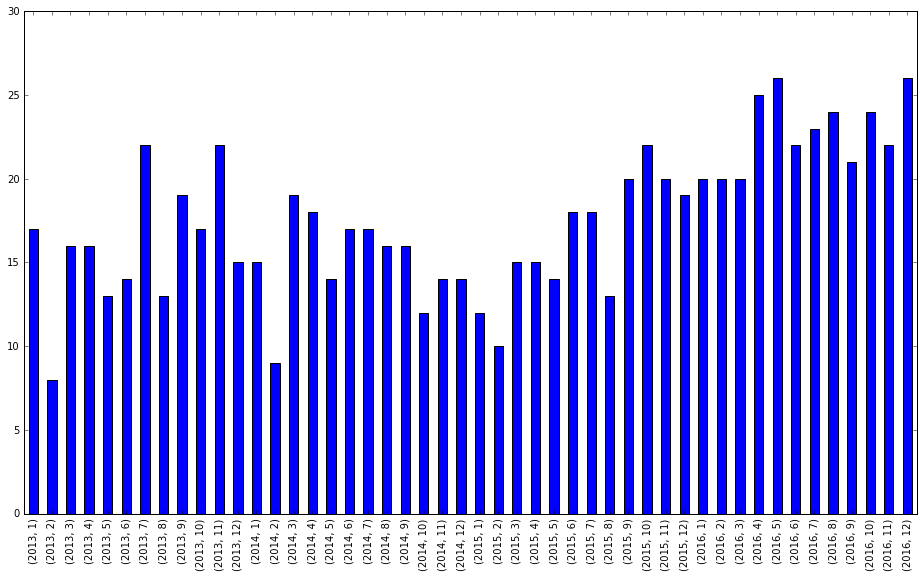

In [129]:
plt.figure(figsize=(16,9), facecolor="white")
pd.Series(result).plot('bar', color='blue')

In [132]:
s = pd.Series(result)
s[:32].describe()

count    32.000000
mean     15.250000
std       3.212877
min       8.000000
25%      13.750000
50%      15.000000
75%      17.000000
max      22.000000
dtype: float64

In [133]:
s[36:].describe()

count    12.000000
mean     22.750000
std       2.261335
min      20.000000
25%      20.750000
50%      22.500000
75%      24.250000
max      26.000000
dtype: float64

In [28]:
result = {}
i915 = commits[commits.isi915]
for year in range(2013, 2017):
    for month in range(1, 13):
        subset = i915[i915.committed_datetime.map(lambda t: t.year * 100 + t.month == year * 100 + month)]
        result[(year, month)] = subset.shape[0] * 1.0 / len(set(subset.committed_datetime.map(lambda t: (t.year*10000 + t.month*100 + t.day))))

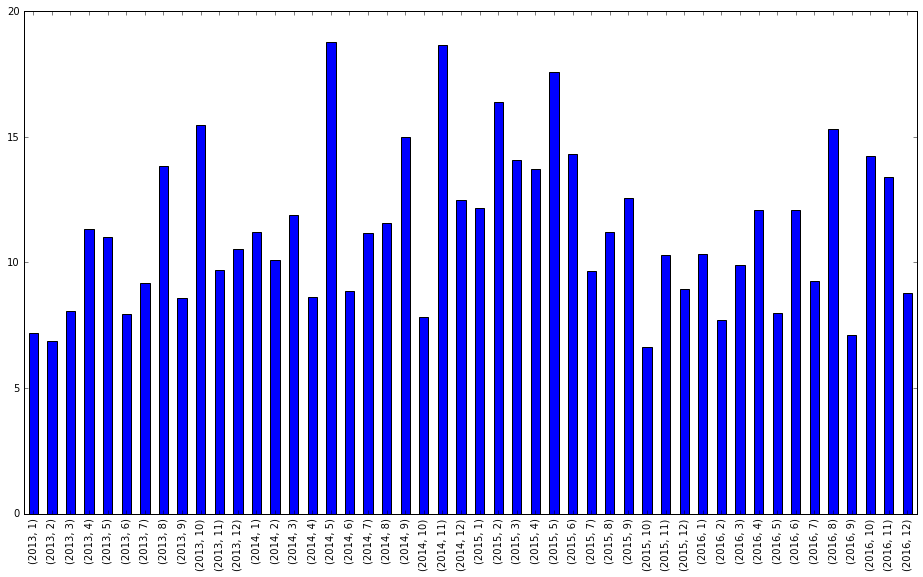

In [29]:
plt.figure(figsize=(16,9), facecolor="white")
pd.Series(result).plot('bar', color='blue')

In [30]:
s = pd.Series(result)
s[:32].describe()

count    32.000000
mean     11.719274
std       3.289522
min       6.875000
25%       9.106952
50%      11.215385
75%      13.901282
max      18.785714
dtype: float64

In [31]:
s[36:].describe()

count    12.000000
mean     10.686556
std       2.715144
min       7.095238
25%       8.576923
50%      10.125000
75%      12.420455
max      15.333333
dtype: float64